# Topic Modeling
## 90-803 Machine Learning Foundations with Python (Spring 2023)
### Name: Team 8 (Grace Kim, Sajujya Gangopadhyay, Alex Yang)

**Imports all the necessary packages we are going to use for data cleaning.**

In [81]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Pre-processing
import nltk
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import ne_chunk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint

# Models
from gensim.models import LsiModel, Phrases, TfidfModel, CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf

# Visualization
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed=2023
#pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package words to /Users/talktalki/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/talktalki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/talktalki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [269]:
# Import netflix movies info dataset 
netflix_titles = pd.read_csv('netflix_titles.csv')
netflix_df = netflix_titles[['title','description']]
netflix_df = netflix_df.rename(columns={"description": "nf_plot"})
netflix_df

,title,nf_plot
0,Dick Johnson Is Dead,"As her father nears the end of his life, filmm..."
1,Blood & Water,"After crossing paths at a party, a Cape Town t..."
2,Ganglands,To protect his family from a powerful drug lor...
3,Jailbirds New Orleans,"Feuds, flirtations and toilet talk go down amo..."
4,Kota Factory,In a city of coaching centers known to train I...
...,...,...
8802,Zodiac,"A political cartoonist, a crime reporter and a..."
8803,Zombie Dumb,"While living alone in a spooky town, a young g..."
8804,Zombieland,Looking to survive in a world taken over by zo...
8805,Zoom,"Dragged from civilian life, a former superhero..."


In [270]:
# Import wikipedia movie plots dataset 
wiki_movies = pd.read_csv('wiki_movie_plots_deduped.csv')
wiki_movies

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


In [271]:
# Just get the plot descriptions
wiki = wiki_movies[['Title', 'Plot']]
wiki = wiki.rename(columns={"Plot": "wiki_plot"})
wiki.head()

,Title,wiki_plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...


In [273]:
# Merge on Movie Title
merged = pd.merge(netflix_df, wiki, left_on='title', right_on='Title')
wiki_df = merged[['Title','nf_plot','wiki_plot']]

# Drop duplicates
wiki_df = wiki_df.drop_duplicates()

wiki_df

,Title,nf_plot,wiki_plot
0,Sankofa,"On a photo shoot in Ghana, an American model s...",The film starts off with an elderly Divine Dru...
1,Avvai Shanmughi,Newly divorced and denied visitation rights wi...,The film starts in a courtroom where a woman J...
2,Jeans,When the father of the man she loves insists t...,Nachiappan is a rich Indian restaurateur in Lo...
4,Minsara Kanavu,A tangled love triangle ensues when a man fall...,Priya Amal Raj (Kajol) lost her mother at a ve...
5,Grown Ups,Mourning the loss of their beloved junior high...,"In 1978, five childhood friends win their juni..."
...,...,...,...
2015,Yanda Kartavya Aahe,Thanks to an arranged marriage that was design...,"Rahul Desai, an employee in a bank weds Swati ..."
2016,You Don't Mess with the Zohan,An Israeli counterterrorism soldier with a sec...,Zohan Dvir (Adam Sandler) is a superhuman Isra...
2017,Young Adult,When a divorced writer gets a letter from an o...,"Mavis Gary (Charlize Theron) is a divorced, al..."
2018,"Yours, Mine and Ours",When a father of eight and a mother of 10 prep...,Frank Beardsley is a Navy Chief Warrant Office...


In [274]:
print("Movies with netflix plots:", netflix_df.shape)
print("Movies with wiki plots:", wiki_df.shape)

Movies with netflix plots: (8807, 2)
Movies with wiki plots: (1968, 3)


### Initial Visualization

<Axes: xlabel='Genre', ylabel='count'>

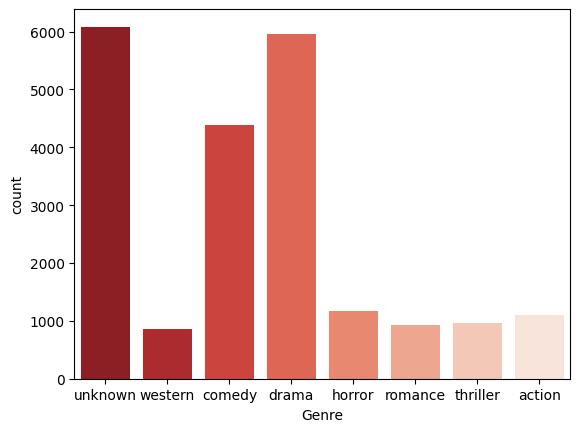

In [261]:
# Count of genres
counts = wiki_movies['Genre'].value_counts()
categories = counts[counts > 700].index
filtered_data = wiki_movies[wiki_movies['Genre'].isin(categories)]

# Create the countplot
sns.countplot(data=filtered_data, x="Genre", palette='RdGy_r')

- There is some imbalance in the genre class - there are more drama/comedy movies than movies from other genres. This is something to keep in mind for the topic clustering at the end.

## II. Text Pre-Processing
* 1: Clean Text
* 2: Tokenization
* 3: Remove Stop words 
* 4: Create Bigram Models
* 5: Lemmatization

In [89]:
# Function for cleaning text
def clean_data(text):
    # change text to lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'[0-9]', "", text)
    text = re.sub('\r\n', " ", text)
    return text

# Function for tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'one', 'two'])

# Functions for stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Function for bigrams
def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize all words in documents.
def lemmatize(tokens_bigrams):
    le = WordNetLemmatizer()
    lemmatized_text = [[le.lemmatize(token) for token in doc] for doc in tokens_bigrams]
    return lemmatized_text

# Lemmatize
nlp = spacy.load('en_core_web_lg')
def lemmatize_spacy(texts, pos = ['NOUN', 'ADJ', 'ADV', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for i in texts:
        doc = nlp(' '.join(i))
        texts_out.append([token.lemma_ for token in doc 
                          if token.ent_type_ != 'PERSON' and token.lemma_ != '-PRON-' and token.pos_ in pos])
    
    return texts_out

### 1. Clean Text

In [90]:
nf_data = netflix_df['nf_plot'].values.tolist()
wiki_data = wiki_df['wiki_plot'].values.tolist()

nf_data = [clean_data(x) for x in nf_data]
wiki_data = [clean_data(x) for x in wiki_data]

### 2. Tokenization

In [275]:
netflix_tokens = list(sent_to_words(nf_data))
wiki_tokens = list(sent_to_words(wiki_data))

print("In the first movie, # of tokens:")
print(len(netflix_tokens[0]), netflix_tokens[0])
print(len(wiki_tokens[0]), wiki_tokens[0])

In the first movie, # of tokens:
27 ['as', 'her', 'father', 'nears', 'the', 'end', 'of', 'his', 'life', 'filmmaker', 'kirsten', 'johnson', 'stages', 'his', 'death', 'in', 'inventive', 'and', 'comical', 'ways', 'to', 'help', 'them', 'both', 'face', 'the', 'inevitable']
975 ['the', 'film', 'starts', 'off', 'with', 'an', 'elderly', 'divine', 'drummer', 'sankofa', 'played', 'by', 'kofi', 'ghanaba', 'beating', 'on', 'african', 'drums', 'chanting', 'the', 'phrase', 'lingering', 'spirit', 'of', 'the', 'dead', 'rise', 'up', 'this', 'is', 'his', 'form', 'of', 'communication', 'with', 'the', 'ancestors', 'of', 'the', 'african', 'land', 'he', 'believes', 'that', 'his', 'drumming', 'is', 'essential', 'in', 'bringing', 'the', 'spirit', 'of', 'his', 'ancestors', 'who', 'were', 'killed', 'in', 'the', 'african', 'diaspora', 'back', 'home', 'the', 'story', 'then', 'goes', 'on', 'to', 'show', 'mona', 'oyafunmike', 'ogunlano', 'contemporary', 'african', 'american', 'model', 'on', 'film', 'shoot', 'in', '

### 3. Remove Stop Words

In [276]:
# Remove Stop Words
netflix_tokens_nostops = remove_stopwords(netflix_tokens)
wiki_tokens_nostops = remove_stopwords(wiki_tokens)

print("After removing stop words:")
print(len(netflix_tokens_nostops[0]), netflix_tokens_nostops[0])
print(len(wiki_tokens_nostops[0]), wiki_tokens_nostops[0])

After removing stop words:
15 ['father', 'nears', 'end', 'life', 'filmmaker', 'kirsten', 'johnson', 'stages', 'death', 'inventive', 'comical', 'ways', 'help', 'face', 'inevitable']
523 ['film', 'starts', 'elderly', 'divine', 'drummer', 'sankofa', 'played', 'kofi', 'ghanaba', 'beating', 'african', 'drums', 'chanting', 'phrase', 'lingering', 'spirit', 'dead', 'rise', 'form', 'communication', 'ancestors', 'african', 'land', 'believes', 'drumming', 'essential', 'bringing', 'spirit', 'ancestors', 'killed', 'african', 'diaspora', 'back', 'home', 'story', 'goes', 'show', 'mona', 'oyafunmike', 'ogunlano', 'contemporary', 'african', 'american', 'model', 'film', 'shoot', 'ghana', 'session', 'cape', 'coast', 'castle', 'know', 'historically', 'used', 'atlantic', 'slave', 'trade', 'disconnected', 'african', 'roots', 'long', 'mona', 'beach', 'modeling', 'encounters', 'mysterious', 'old', 'man', 'sankofa', 'beating', 'drums', 'beginning', 'film', 'sankofa', 'persistently', 'reminds', 'mona', 'return'

### 4. Bigram

In [277]:
# Build the bigram models (only ones that appear 5 times or more).
netflix_bigram = gensim.models.Phrases(netflix_tokens_nostops, min_count=5, threshold=100) # higher threshold fewer phrases.
netflix_bigram_mod = gensim.models.phrases.Phraser(netflix_bigram)

wiki_bigram = gensim.models.Phrases(wiki_tokens_nostops, min_count=5, threshold=100) # higher threshold fewer phrases.
wiki_bigram_mod = gensim.models.phrases.Phraser(wiki_bigram)

In [278]:
# Form Bigrams
netflix_tokens_bigrams = make_bigrams(netflix_bigram_mod, netflix_tokens_nostops)
wiki_tokens_bigrams = make_bigrams(wiki_bigram_mod, wiki_tokens_nostops)

print("After considering bigrams:")
print(len(netflix_tokens_bigrams[0]), netflix_tokens_bigrams[0])
print(len(wiki_tokens_bigrams[0]), wiki_tokens_bigrams[0])

After considering bigrams:
15 ['father', 'nears', 'end', 'life', 'filmmaker', 'kirsten', 'johnson', 'stages', 'death', 'inventive', 'comical', 'ways', 'help', 'face', 'inevitable']
519 ['film', 'starts', 'elderly', 'divine', 'drummer', 'sankofa', 'played', 'kofi', 'ghanaba', 'beating', 'african', 'drums', 'chanting', 'phrase', 'lingering', 'spirit', 'dead', 'rise', 'form', 'communication', 'ancestors', 'african', 'land', 'believes', 'drumming', 'essential', 'bringing', 'spirit', 'ancestors', 'killed', 'african', 'diaspora', 'back', 'home', 'story', 'goes', 'show', 'mona', 'oyafunmike', 'ogunlano', 'contemporary', 'african_american', 'model', 'film', 'shoot', 'ghana', 'session', 'cape', 'coast', 'castle', 'know', 'historically', 'used', 'atlantic', 'slave', 'trade', 'disconnected', 'african', 'roots', 'long', 'mona', 'beach', 'modeling', 'encounters', 'mysterious', 'old', 'man', 'sankofa', 'beating', 'drums', 'beginning', 'film', 'sankofa', 'persistently', 'reminds', 'mona', 'return', '

### 5. Lemmatization

In [95]:
nf_lemmatized = lemmatize_spacy(netflix_tokens_bigrams)
wiki_lemmatized = lemmatize_spacy(wiki_tokens_bigrams)

### End of Preprocessing - let's compare:

In [279]:
print("Finally, after lemmatization:")
print(len(nf_lemmatized[0]), nf_lemmatized[0])
print(len(wiki_lemmatized[0]), wiki_lemmatized[0])
print("\n")
print("Original:")
print(len(netflix_df['nf_plot'][0]), netflix_df['nf_plot'][0])
print(len(wiki_df['wiki_plot'][0]), wiki_df['wiki_plot'][0])

Finally, after lemmatization:
12 ['near', 'end', 'life', 'filmmaker', 'stage', 'death', 'inventive', 'comical', 'way', 'help', 'face', 'inevitable']
389 ['film', 'start', 'elderly', 'divine', 'drummer', 'play', 'beat', 'drum', 'chant', 'phrase', 'linger', 'spirit', 'dead', 'rise', 'form', 'communication', 'ancestor', 'african', 'land', 'believe', 'drum', 'essential', 'bring', 'spirit', 'ancestor', 'kill', 'back', 'home', 'story', 'go', 'show', 'contemporary', 'african_american', 'model', 'film', 'shoot', 'know', 'historically', 'use', 'slave', 'trade', 'disconnect', 'african', 'root', 'long', 'beach', 'modeling', 'encounter', 'mysterious', 'old', 'man', 'beat', 'drum', 'begin', 'film', 'persistently', 'remind', 'return', 'belligerent', 'come', 'keep', 'place', 'ancestor', 'sacred', 'attempt', 'kick', 'white', 'tourist', 'slave', 'decide', 'go', 'take', 'look', 'castle', 'trap', 'enter', 'sort', 'trance', 'surround', 'chain', 'slave', 'appear', 'rise', 'dead', 'attempt', 'run', 'slave',

In [280]:
# Dataframe to record how text processing worked
preprocessing_steps = ['Tokens', 'StopWords', 'Bigrams', 'Lemmatization']
nf_change = [len(netflix_tokens[0]), len(netflix_tokens_nostops[0]), len(netflix_tokens_bigrams[0]), len(nf_lemmatized[0])]
wiki_change = [len(wiki_tokens[0]), len(wiki_tokens_nostops[0]), len(wiki_tokens_bigrams[0]), len(wiki_lemmatized[0])]

change_df = pd.DataFrame({"Preprocessing Steps": preprocessing_steps,
                          "Netflix Dataset": nf_change,
                          "Wikipedia Dataset": wiki_change})
change_df

,Preprocessing Steps,Netflix Dataset,Wikipedia Dataset
0,Tokens,27,975
1,StopWords,15,523
2,Bigrams,15,519
3,Lemmatization,12,389


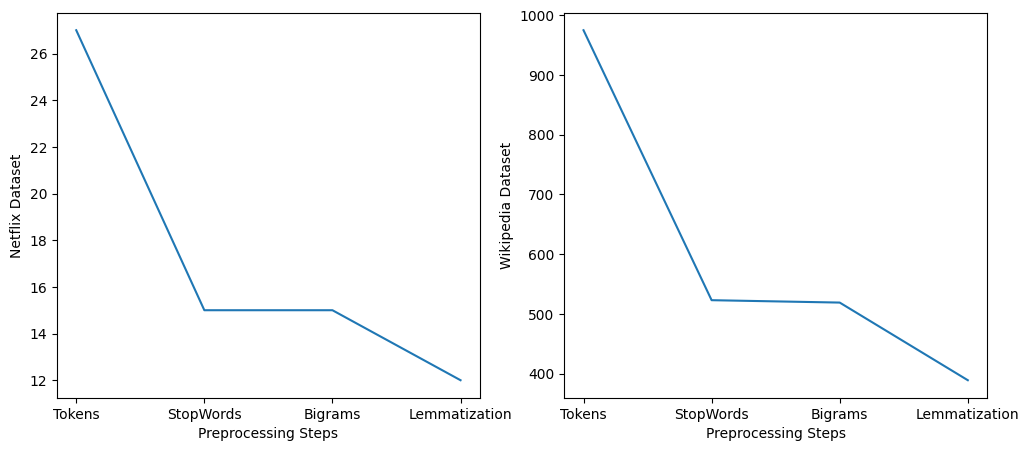

In [281]:
# Lineplot to visualize how text processing worked
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.lineplot(ax=ax[0], data=change_df, x='Preprocessing Steps', y='Netflix Dataset')
sns.lineplot(ax=ax[1], data=change_df, x='Preprocessing Steps', y='Wikipedia Dataset')

# Show plot
plt.show()

- Text processing was successful in reducing the descriptions down to only relevant necessary words.

In [282]:
# Add processed text as new column
netflix_df['nf_lem'] = nf_lemmatized
wiki_df['wiki_lem'] = wiki_lemmatized

# Add a word count column
def word_count(text):
    return len(str(text).split(' '))

netflix_df['nf_word_count'] = netflix_df['nf_plot'].apply(word_count)
netflix_df.head()

,title,nf_plot,nf_lem,nf_word_count
0,Dick Johnson Is Dead,"As her father nears the end of his life, filmm...","[near, end, life, filmmaker, stage, death, inv...",27
1,Blood & Water,"After crossing paths at a party, a Cape Town t...","[crossing, path, town, teen, set, prove, priva...",27
2,Ganglands,To protect his family from a powerful drug lor...,"[protect, family, powerful, drug_lord, skilled...",27
3,Jailbirds New Orleans,"Feuds, flirtations and toilet talk go down amo...","[feud, flirtation, toilet, talk, go, incarcera...",24
4,Kota Factory,In a city of coaching centers known to train I...,"[city, coaching, center, know, train, fine, mi...",24


In [283]:
wiki_df['wiki_word_count'] = wiki_df['wiki_plot'].apply(word_count)
wiki_df.head()

,Title,nf_plot,wiki_plot,wiki_lem,wiki_word_count
0,Sankofa,"On a photo shoot in Ghana, an American model s...",The film starts off with an elderly Divine Dru...,"[film, start, elderly, divine, drummer, play, ...",995
1,Avvai Shanmughi,Newly divorced and denied visitation rights wi...,The film starts in a courtroom where a woman J...,"[film, start, courtroom, woman, fight, husband...",572
2,Jeans,When the father of the man she loves insists t...,Nachiappan is a rich Indian restaurateur in Lo...,"[los_angele, twin, son, senior, medical, stude...",544
4,Minsara Kanavu,A tangled love triangle ensues when a man fall...,Priya Amal Raj (Kajol) lost her mother at a ve...,"[lose, mother, young, age, friendly, outspoken...",480
5,Grown Ups,Mourning the loss of their beloved junior high...,"In 1978, five childhood friends win their juni...","[childhood, friend, win, junior, basketball, c...",883


### Visualization of Tokens

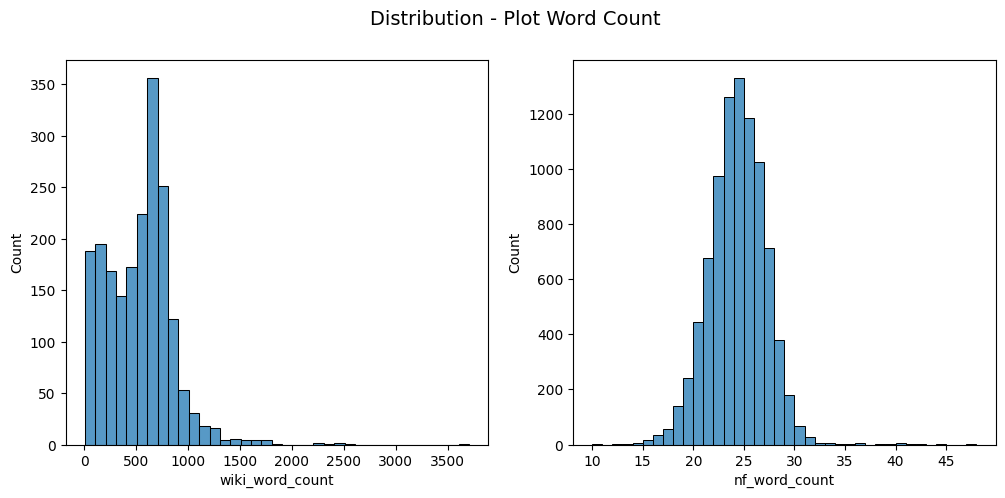

In [296]:
# Plot a histogram of the word counts
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.histplot(ax=ax[0], x='wiki_word_count', data=wiki_df, binwidth=100)
sns.histplot(ax=ax[1], x='nf_word_count', data=netflix_df, binwidth=1)

fig.suptitle('Distribution - Plot Word Count', fontsize=14)
plt.show()

- Most plot descriptions from the netflix dataset were around 25 words.
- Most plot descriptions from the wikipedia dataset were around 700 words.

In [100]:
# Top 20 most common words among all the wikipedia movie descriptions
p_text = wiki_df['wiki_lem']

# Flatten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(Counter(p_text).most_common(20), columns=['word', 'frequency'])
top_20

,word,frequency
0,find,3092
1,kill,2893
2,take,2740
3,go,2680
4,tell,2640
5,leave,2537
6,get,2055
7,make,1872
8,man,1809
9,see,1775


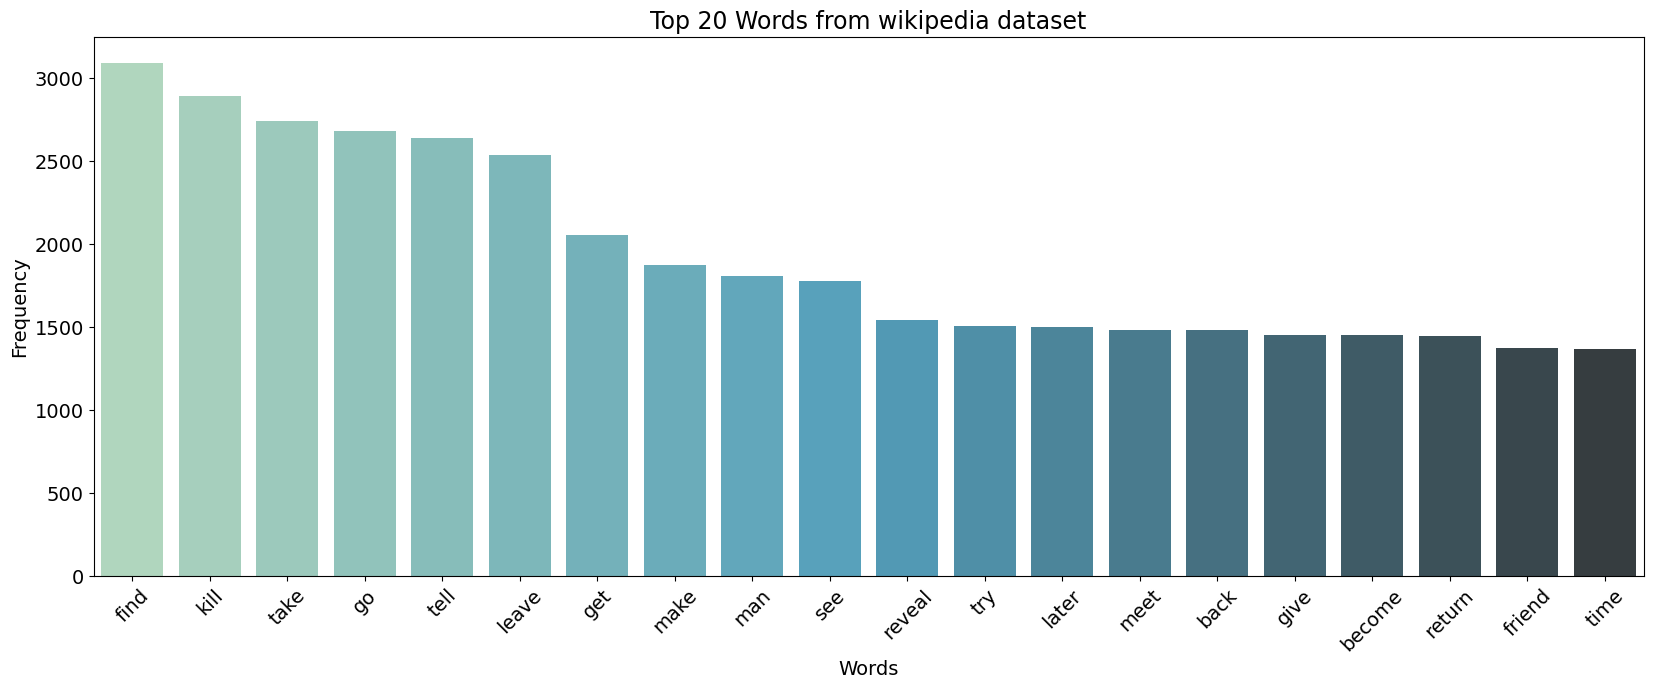

In [297]:
# Visualization of Top 20 Words
fig = plt.figure(figsize=(20,7))

bplot = sns.barplot(x='word', y='frequency', data=top_20, palette='GnBu_d')

bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, fontsize=14)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words from wikipedia dataset', fontsize=17)

plt.show()

### Bag of Words on the Dataset

In [102]:
# Create Dictionary
nf_dict = corpora.Dictionary(nf_lemmatized)
wiki_dict = corpora.Dictionary(wiki_lemmatized)

# Filter out words that occur less than 20 documents, or more than 70% of the documents.
nf_dict.filter_extremes(no_below=20, no_above=0.7)
wiki_dict.filter_extremes(no_below=20, no_above=0.7)

# Term Document Frequency (bag-of-words representation of the corpus)
nf_bow_corpus = [nf_dict.doc2bow(text) for text in nf_lemmatized]
wiki_bow_corpus = [wiki_dict.doc2bow(text) for text in wiki_lemmatized]

# mapping of (word_id, word_frequency)
#nf_bow_corpus
#wiki_bow_corpus

In [298]:
print('Netflix: Number of unique tokens: %d' % len(nf_dict))
print('Netflix: Number of documents: %d' % len(nf_bow_corpus))
print('Wiki: Number of unique tokens: %d' % len(wiki_dict))
print('Wiki: Number of documents: %d' % len(wiki_bow_corpus))

Netflix: Number of unique tokens: 1041
Netflix: Number of documents: 8807
Wiki: Number of unique tokens: 2366
Wiki: Number of documents: 1968


### TFIDF on the Dataset

In [104]:
# Create TFIDF Model for more accuracy
nf_tfidf = TfidfModel(nf_bow_corpus)
nf_corpus_tfidf = nf_tfidf[nf_bow_corpus]

wiki_tfidf = TfidfModel(wiki_bow_corpus)
wiki_corpus_tfidf = wiki_tfidf[wiki_bow_corpus]

## III. Modeling

### Model #1: LDA Model

In [105]:
# Function to build LDA model
def lda_model(corpus, dict, n):   
    model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dict,
                                       num_topics=n, 
                                       random_state=seed,
                                       chunksize=2000,
                                       passes=20,
                                       per_word_topics=True)
    return model

In [106]:
# Function to get topics
def get_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [107]:
# Baseline LDA Model - Bag of Words
nf_lda_model = lda_model(nf_bow_corpus, nf_dict, 5)
wiki_lda_model = lda_model(wiki_bow_corpus, wiki_dict, 5)

# LDA Model - using TFIDF
nf_lda_model_tfidf = lda_model(nf_corpus_tfidf, nf_dict, 5)
wiki_lda_model_tfidf = lda_model(wiki_corpus_tfidf, wiki_dict, 5)

In [108]:
# Get Topics for netflix dataset
get_topics(nf_lda_model_tfidf, 5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,murder,young,team,show,adventure
1,crime,woman,documentary,life,friend
2,take,man,life,music,life
3,detective,family,new,documentary,world
4,death,find,follow,comedian,love
5,life,daughter,world,special,series
6,case,home,take,take,live
7,investigate,mother,woman,stage,fun
8,cop,son,mission,actor,explore
9,man,couple,find,comedy,share


In [109]:
# Get Topics for wikipedia dataset
get_topics(wiki_lda_model_tfidf, 5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,companion,star,fiance,dislike,kill
1,beautiful,bill,research,conspiracy,family
2,criminal,concert,establish,chinese,tell
3,escape,play,original,engineer,man
4,become,client,relative,center,police
5,cafe,task,aunt,problem,money
6,relative,aspire,sink,young,get
7,solve,international,shake,stop,mother
8,play,quiet,survivor,discover,love
9,story,british,ship,film,friend


### Model #2: LSA Model

In [110]:
# Function to build LSA model
def lsa_model(corpus, dict, n):
    model = LsiModel(corpus=corpus,
                     id2word=dict,
                     num_topics=n,
                     chunksize=2000,
                     random_seed=seed)
    return model

In [111]:
# Baseline LSA Model with Bag of Words
nf_lsa_model = lsa_model(nf_bow_corpus, nf_dict, 5)
wiki_lsa_model = lsa_model(wiki_bow_corpus, wiki_dict, 5)

# LSA Model with TFIDF
nf_lsa_model_tfidf = lsa_model(nf_corpus_tfidf, nf_dict, 5)
wiki_lsa_model_tfidf = lsa_model(wiki_corpus_tfidf, wiki_dict, 5)

### Model #3: NMF Model

In [112]:
# Function to build NMF model
def nmf_model(corpus, dict, n):   
    model = GensimNmf(
        corpus=list(corpus),
        id2word=dict,
        num_topics=n,
        chunksize=2000,
        passes=20,
        eval_every=10,
        minimum_probability=0,
        random_state=seed,
        kappa=1
    )
    return model

In [113]:
# Baseline NMF Model with Bag of Words
nf_nmf_model = nmf_model(nf_bow_corpus, nf_dict, 5)
wiki_nmf_model = nmf_model(wiki_bow_corpus, wiki_dict, 5)

# NMF Model with TFIDF
nf_nmf_model_tfidf = nmf_model(nf_corpus_tfidf, nf_dict, 5)
wiki_nmf_model_tfidf = nmf_model(wiki_corpus_tfidf, wiki_dict, 5)

In [114]:
get_topics(nf_nmf_model_tfidf, 5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,family,love,take,friend,life
1,live,world,find,new,documentary
2,home,make,man,become,story
3,go,fall,young,good,series
4,child,help,woman,begin,follow
5,man,woman,year,turn,explore
6,couple,learn,way,move,film
7,father,get,daughter,adventure,bring
8,secret,meet,son,save,personal
9,get,day,murder,evil,base


In [115]:
get_topics(wiki_nmf_model_tfidf, 5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,police,team,love,ship,room
1,kill,game,marry,alien,car
2,money,school,family,earth,house
3,murder,student,mother,human,body
4,gang,win,wedding,destroy,kill
5,shoot,play,marriage,crew,woman
6,arrest,film,friend,soldier,town
7,car,player,relationship,power,hotel
8,officer,coach,parent,use,tell
9,man,fight,girl,machine,child


### Model #4: K Means

In [245]:
vec = TfidfVectorizer(
  max_features=5000, 
  stop_words="english", 
  max_df=0.80, 
  min_df=10,
 #preprocessor=''.join(x)
)

data = wiki_df['wiki_lem'].apply(lambda x: ', '.join(x))

features = vec.fit_transform(data)
features

<1968x3798 sparse matrix of type '<class 'numpy.float64'>'
	with 224502 stored elements in Compressed Sparse Row format>

Text(0, 0.5, 'WCSS')

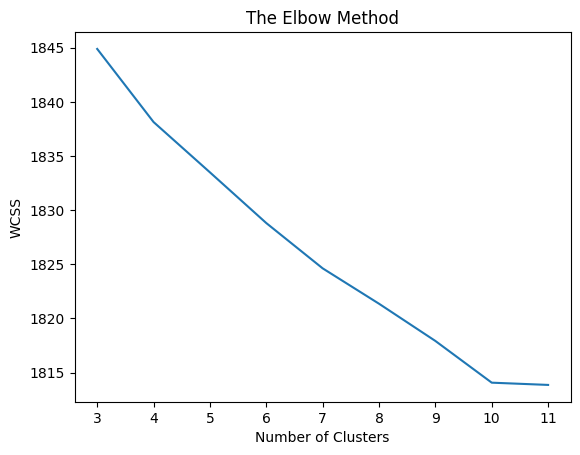

In [249]:
from sklearn.cluster import KMeans
wcss=[]

for i in range(3,12):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=seed)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.plot(range(3,12), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

In [251]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=seed)
kmeans.fit(features)

wiki_df['kmeans_cluster'] = kmeans.labels_
wiki_df['kmeans_cluster'].value_counts()
#wiki_df[wiki_df['kmeans_cluster']==1]['wiki_lem'].head(10)

3    649
0    498
2    436
1    385
Name: kmeans_cluster, dtype: int64

## IV. Hyperparameter Tuning

In [195]:
# Function that evaluates performance
def compute_coherence_score(model, text, dict):
    coherence_model_lda = CoherenceModel(model=model, texts=text, dictionary=dict, coherence='c_v')
    return coherence_model_lda.get_coherence()

def compute_perplexity_score(model, corpus):
    return model.log_perplexity(corpus)

In [201]:
# Hyperparameter to tune is number of topics
topic_nums = range(1,11,1)

In [202]:
# Tuning for LDA model
lda_coherence_scores=[]

for n in topic_nums:
    wiki_lda_model_tfidf = lda_model(wiki_corpus_tfidf, wiki_dict, n) 
    score = compute_coherence_score(wiki_lda_model_tfidf, wiki_lemmatized, wiki_dict)
    lda_coherence_scores.append((n,score))
    print(lda_coherence_scores[n-1])

(1, 0.3083746436031355)
(2, 0.40272540315474037)
(3, 0.44092407898681113)
(4, 0.33380024131336683)
(5, 0.2690627262452841)
(6, 0.26315635179628066)
(7, 0.26193641029888803)
(8, 0.2828180224185971)
(9, 0.27016108930882976)
(10, 0.2452523827269614)


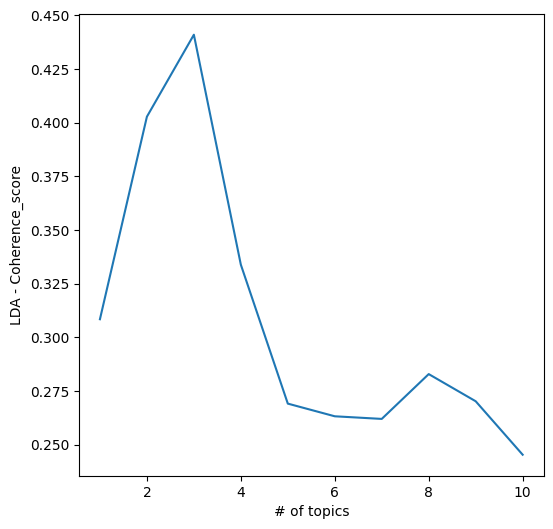

In [203]:
x,y=zip(*lda_coherence_scores)

plt.figure(figsize=(6,6))
plt.plot(x,y)
plt.ylabel('LDA - Coherence_score')
plt.xlabel('# of topics')
plt.show()

In [204]:
# Tuning for LDA model
nmf_coherence_scores=[]

for n in topic_nums:
    wiki_nmf_model_tfidf = nmf_model(wiki_corpus_tfidf, wiki_dict, n)
    score = compute_coherence_score(wiki_nmf_model_tfidf, wiki_lemmatized, wiki_dict)
    nmf_coherence_scores.append((n,score))
    print(nmf_coherence_scores[n-1])

(1, 0.3104732384773946)
(2, 0.39229155148481193)
(3, 0.4970227919498995)
(4, 0.4142075122008839)
(5, 0.46858674748229434)
(6, 0.4035169689200377)
(7, 0.4314853721127231)
(8, 0.455334339856571)
(9, 0.43524359740226115)
(10, 0.40123453961489747)


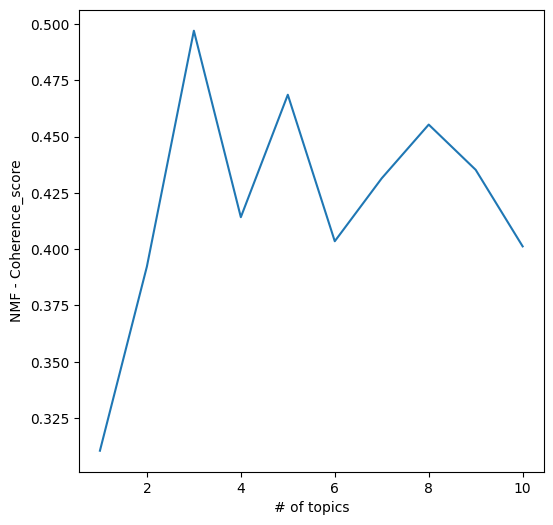

In [205]:
x,y=zip(*nmf_coherence_scores)

plt.figure(figsize=(6,6))
plt.plot(x, y)
plt.ylabel('NMF - Coherence_score')
plt.xlabel('# of topics')
plt.show()

In [206]:
# Best hyperparameter
max_score = 0
for i in lda_coherence_scores:
    if i[1] > max_score:
        max_score = i[1]
        lda_best_num_topics = i[0]
print("Best # of topics for LDA model:", lda_best_num_topics)

for i in nmf_coherence_scores:
    if i[1] > max_score:
        max_score = i[1]
        nmf_best_num_topics = i[0]
print("Best # of topics for NMF model:", nmf_best_num_topics)

Best # of topics for lda model: 3
Best # of topics for nmf model: 3


In [207]:
# Use best hyperparameter to tune models

# Tuned LDA
nf_lda_tuned_model = lda_model(nf_corpus_tfidf, nf_dict, lda_best_num_topics)
wiki_lda_tuned_model = lda_model(wiki_corpus_tfidf, wiki_dict, lda_best_num_topics)

# Tuned LSA
nf_lsa_tuned_model = lsa_model(nf_corpus_tfidf, nf_dict, lda_best_num_topics)
wiki_lsa_tuned_model = lsa_model(wiki_corpus_tfidf, wiki_dict, lda_best_num_topics)

# Tuned NMF Model
nf_nmf_tuned_model = nmf_model(nf_corpus_tfidf, nf_dict, nmf_best_num_topics)
wiki_nmf_tuned_model = nmf_model(wiki_corpus_tfidf, wiki_dict, nmf_best_num_topics)

## V. Performance Evaluation

In [208]:
# Compute Coherence/Perplexity Score for all models
dataset = ['Netflix']*6 + ['Wiki']*6
model = ['LDA','LDA','LSA','LSA','NMF','NMF'] * 2
method = ['Bag of Words','TFIDF'] * 6

lda_coherence_scores = [compute_coherence_score(nf_lda_model, nf_lemmatized, nf_dict),
compute_coherence_score(nf_lda_tuned_model, nf_lemmatized, nf_dict),
compute_coherence_score(nf_lsa_model, nf_lemmatized, nf_dict),
compute_coherence_score(nf_lsa_tuned_model, nf_lemmatized, nf_dict),
compute_coherence_score(nf_nmf_model, nf_lemmatized, nf_dict),
compute_coherence_score(nf_nmf_tuned_model, nf_lemmatized, nf_dict),
compute_coherence_score(wiki_lda_model, wiki_lemmatized, wiki_dict),
compute_coherence_score(wiki_lda_tuned_model, wiki_lemmatized, wiki_dict),
compute_coherence_score(wiki_lsa_model, wiki_lemmatized, wiki_dict),
compute_coherence_score(wiki_lsa_tuned_model, wiki_lemmatized, wiki_dict),
compute_coherence_score(wiki_nmf_model, wiki_lemmatized, wiki_dict),
compute_coherence_score(wiki_nmf_tuned_model, wiki_lemmatized, wiki_dict)]

# Create a dataframe of all scores
bestmodel_df = pd.DataFrame({'Dataset': dataset,
                             'Model': model,
                             'Method': method,
                             'Coherence score': lda_coherence_scores})
bestmodel_df

,Dataset,Model,Method,Coherence score
0,Netflix,LDA,Bag of Words,0.267623
1,Netflix,LDA,TFIDF,0.260058
2,Netflix,LSA,Bag of Words,0.271740
3,Netflix,LSA,TFIDF,0.343727
4,Netflix,NMF,Bag of Words,0.288437
5,Netflix,NMF,TFIDF,0.250249
6,Wiki,LDA,Bag of Words,0.280236
7,Wiki,LDA,TFIDF,0.440924
8,Wiki,LSA,Bag of Words,0.345574
9,Wiki,LSA,TFIDF,0.468425


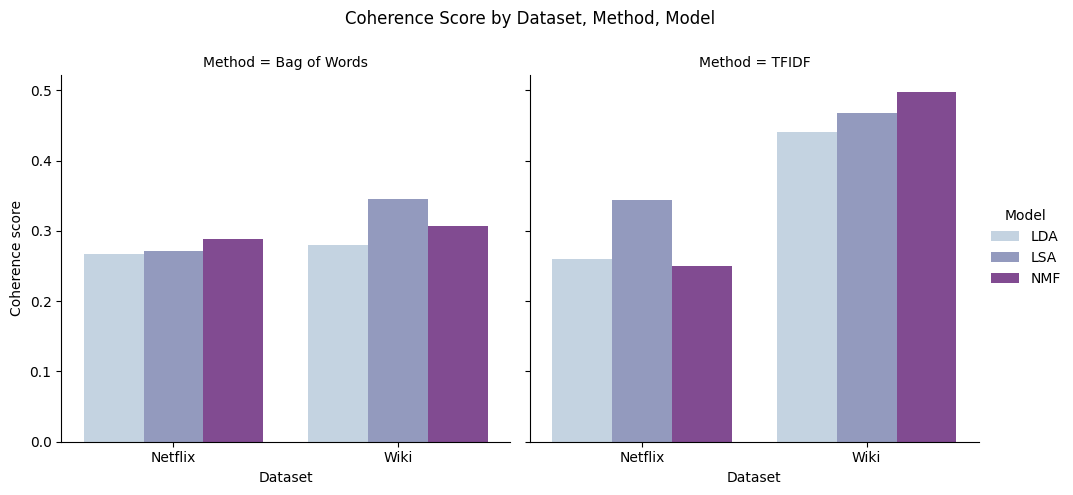

In [209]:
# Visualization of coherence scores for comparison
sns.catplot(data=bestmodel_df, x="Dataset", y="Coherence score", hue="Model", col='Method', palette='BuPu', kind='bar')

plt.suptitle("Coherence Score by Dataset, Method, Model")
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()

- Coherence score measures the quality of the topic model by evaluating how interpretable and coherent the topics generated by the model are. A higher coherence score indicates that the topics generated by the model are more interpretable and coherent.
- Between Netflix and Wikipedia dataset, Wikipedia dataset performed better. This makes sense since it had a lot more tokens to work with.
- Between Bag of Words method and TFIDF method, using TFIDF for wikipedia dataset resulted in much higher performance.
- Between LDA, LSA, and NMF models, LSA and NMF models performed better. 
- Out of all combinations, NMF model using TFIDF method on the Wikipedia dataset proved to perform the best.

### Visualization for the LDA Models

In [210]:
LDAvis_prepared = pyLDAvis.gensim.prepare(nf_lda_tuned_model, nf_corpus_tfidf, nf_dict)
LDAvis_prepared

/opt/homebrew/lib/python3.11/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.134534 -0.050443       1        1  36.500636
0     -0.121512 -0.068606       2        1  32.012059
2     -0.013022  0.119049       3        1  31.487305, topic_info=            Term       Freq       Total Category  logprob  loglift
142     daughter  63.000000   63.000000  Default  30.0000  30.0000
114       couple  54.000000   54.000000  Default  29.0000  29.0000
337  documentary  90.000000   90.000000  Default  28.0000  28.0000
728     personal  40.000000   40.000000  Default  27.0000  27.0000
250       mother  59.000000   59.000000  Default  26.0000  26.0000
..           ...        ...         ...      ...      ...      ...
21        family  37.914917  136.562247   Topic3  -5.2840  -0.1259
86         group  29.439593   68.290481   Topic3  -5.5370   0.3142
32         woman  34.190548  133.968921   Topic3  -5.3874  -0.2101
47         young  34.318372  138.749461   Topic3  -5.3837  -0.2414
55        become  31.768846   97.241503   Topic3  -5.4609   0.0369

[249 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
704       1  0.944269    abandon
704       2  0.067448    abandon
794       3  0.965214   activist
148       1  0.255559  adventure
148       2  0.119261  adventure
...     ...       ...        ...
248       2  0.263485       year
248       3  0.225844       year
47        1  0.576579      young
47        2  0.172974      young
47        3  0.245046      young

[451 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [255]:
LDAvis_prepared = pyLDAvis.gensim.prepare(wiki_lda_tuned_model, wiki_corpus_tfidf, wiki_dict)
LDAvis_prepared

/opt/homebrew/lib/python3.11/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.046612  0.028900       1        1  80.514995
1      0.075938  0.004746       2        1  13.521990
0     -0.029325 -0.033647       3        1   5.963015, topic_info=         Term       Freq      Total Category  logprob  loglift
687    police  30.000000  30.000000  Default  30.0000  30.0000
94       kill  41.000000  41.000000  Default  29.0000  29.0000
962    murder  23.000000  23.000000  Default  28.0000  28.0000
922      gang  15.000000  15.000000  Default  27.0000  27.0000
864     money  31.000000  31.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
158     shoot   2.170349  22.432469   Topic3  -6.1025   0.4840
300   brother   2.160701  24.574510   Topic3  -6.1069   0.3883
935   officer   2.008576  16.189663   Topic3  -6.1799   0.7326
109       man   2.005536  32.489006   Topic3  -6.1814   0.0346
219  daughter   1.922820  25.697824   Topic3  -6.2235   0.2270

[197 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2279      1  0.333564  accomplice
2279      3  0.333564  accomplice
951       1  0.227308    activate
951       2  0.909233    activate
430       1  0.538745       agent
...     ...       ...         ...
196       3  0.035206       woman
290       1  0.924104        work
290       2  0.038504        work
290       3  0.038504        work
1169      1  0.945051       write

[365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

### Findings
- Best number of topics is 3 for both LDA and NMF models.
    - Topic 1 (family, love, friend, child, car) seems like it clustered the drama genre. It includes 80% of the movies - this makes sense since we had a higher proportion of comedy and drama genres in this movie dataset to begin with.
    - Topic 2 includes words like: kill, soldier, ship, escape, attack, human, bomb, war - which may be movies on the topic war.
    - Topic 3 includes words like: criminal, murder, gang, police, prison, cop, kill - which may be movies on the topic crime. 

### References

* https://spacy.io/usage/linguistic-features
* https://tedboy.github.io/nlps/generated/generated/gensim.models.LdaMulticore.html?highlight=ldamulti#gensim.models.LdaMulticore
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
* https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
* https://datascience.oneoffcoder.com/topic-modeling-gensim.html
* https://pub.towardsai.net/topic-modeling-with-nmf-for-user-reviews-classification-65913d0b44fe
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://notebook.community/piskvorky/gensim/docs/notebooks/nmf_tutorial
* https://www.datacamp.com/tutorial/discovering-hidden-topics-python
* https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf
* https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots
* https://www.kaggle.com/code/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn
* https://www.kaggle.com/code/aiswaryaramachandran/content-based-movie-recommendation-system
* https://www.kaggle.com/code/nicolesim/content-based-recommender-system-with-lda-cosine
* https://github.com/Siddharthsuresh92/Topic-Modeling-Movie-Plots/blob/master/Movie%20Plots%20-%20Topic%20Modeling%20Exploration.ipynb
* https://nkoenig06.github.io/gd-tm-cluster.html